# Modeling the potential of CRISPR gene drives for mosquito suppression
<hr style="border:2px solid gray"> </hr>
This notebook is for generating models with GP utilizing code generated by Sam E Champer.

First, some imports:

In [2]:
#pip install tensorflow==2.12.0

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Dropout, concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, reciprocal
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd
import scipy
import copy
import matplotlib.colors as colors
%matplotlib inline

In [3]:
# define parameters calculate shap values for different kind of parameters separatly or combined
oldnames=['malaria_takein_rate', 'malaria_sensitive', 'distance', 'remate_chance',
       'want_to_bite_rate', 'animal_bite_rate', 'dd_fitness_value',
       'somatic_fitness_multiplier_f', 'grc_beta', 'drive_conversion', 'erc_f',
       'r1_occurrence_rate', 'low_density_growth_rate', 'seasonal_amplitude',
       'cureweek', 'immunity']

newname=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'average dispersal',
        'weekly remating chance',
        'mosquito reproduction chance', 
        'animal biting rate',
        'viability fitness', 
        'female fecundity fitness',
        'germline resistance rate',
        'drive conversion efficiency',
        'embryo resistance rate', 
        'functional resistance proportion',
        'low-density growth rate',
        'seasonal population change',
        'infection duration',
        'immunity duration']
mosquito_parameter=['average dispersal','weekly remating chance','mosquito reproduction chance','animal biting rate','viability fitness','female fecundity fitness','germline resistance rate','drive conversion efficiency',
                             'embryo resistance rate','functional resistance proportion','low-density growth rate','seasonal population change']
null_drive=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'average dispersal',
        'weekly remating chance',
        'mosquito reproduction chance', 
        'animal biting rate',
        'low-density growth rate',
        'seasonal population change',
        'infection duration',
        'immunity duration']
malaria_only=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'infection duration',
        'immunity duration']


<hr style="border:1px solid gray"> </hr>

## 0. load the datas and do normalization


In [4]:
#load the data
Train_ave=pd.read_csv('Train_ave2.csv')
Test_ave=pd.read_csv('Test_ave2.csv')

In [13]:
#normalize data
abs_scaler1 = MaxAbsScaler()
# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler1.fit(Train_ave.loc[:,newname])
# the maximum absolute values calculated by the fit method
abs_scaler1.max_abs_
# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler1.transform(Train_ave.loc[:,newname])
# store the results in a data frame
Train_scaled = pd.DataFrame(scaled_data, columns=newname)

In [14]:

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler1.transform(Test_ave.loc[:,newname])
# store the results in a data frame
Test_scaled = pd.DataFrame(scaled_data, columns=newname)

In [15]:
X_train = Train_scaled.loc[:,newname]
y_train = Train_ave.loc[:,['malaria_eliminated', 'malaria_prevalence','suppressed','mosquito_prev']]
X_test = Test_scaled.loc[:,newname]
y_test = Test_ave.loc[:,['malaria_eliminated','malaria_prevalence', 'suppressed','mosquito_prev']]

In [16]:
column_dtypes = y_train.dtypes
print(column_dtypes)

malaria_eliminated    float64
malaria_prevalence    float64
suppressed            float64
mosquito_prev         float64
dtype: object


In [17]:
X_train

,transmission rate to mosquitoes,transmission rate to humans,average dispersal,weekly remating chance,mosquito reproduction chance,animal biting rate,viability fitness,female fecundity fitness,germline resistance rate,drive conversion efficiency,embryo resistance rate,functional resistance proportion,low-density growth rate,seasonal population change,infection duration,immunity duration
0,0.191852,0.418889,0.375152,0.313,0.889,0.519,0.991,0.544,0.170971,0.820,0.188993,0.308,0.444444,0.375,0.500000,0.30
1,0.497037,0.878889,0.909697,0.673,0.290,0.285,0.987,0.671,0.789489,0.975,0.249906,0.901,0.222222,0.625,0.633333,0.15
2,0.761111,0.275556,0.745455,0.423,0.459,0.969,0.855,0.696,0.533433,0.990,0.320826,0.935,0.888889,0.875,0.600000,0.90
3,0.704074,0.404444,0.515758,0.043,0.346,0.581,0.935,0.741,0.731532,0.967,0.165979,0.613,0.666667,0.875,0.833333,0.85
4,0.464444,0.262222,0.675152,0.802,0.562,0.879,0.916,0.628,0.108008,0.918,0.275297,0.080,0.500000,1.000,0.633333,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9770,0.271852,0.405556,0.516364,0.886,0.768,0.066,0.886,0.635,0.788989,0.930,0.079675,0.438,0.222222,0.375,0.600000,0.60
9771,0.308519,1.000000,0.673939,0.486,0.387,0.699,0.991,0.786,0.824324,0.935,0.439024,0.619,0.888889,0.875,0.466667,0.40
9772,0.554815,0.262222,0.517576,0.833,0.514,0.160,0.817,0.822,0.787888,0.949,0.170356,0.984,0.111111,0.875,0.666667,0.15
9773,0.238148,0.722222,0.784242,0.808,0.649,0.901,0.878,0.703,0.546046,0.819,0.384740,0.263,0.111111,0.875,0.500000,0.75


<hr style="border:1px solid gray"> </hr>

## 1. load the models

Load the models with 3layers, the optimized model can predict the probability to eliminate malaria/eliminate mosquito and the final malaria prevalence/ mosquito density

In [18]:
class AveragedModel:
    def __init__(self, model_files):
        self.models = [load_model(file) for file in model_files]

    def predict(self, input_data):
        # gain predictions
        predictions = np.array([model.predict(input_data) for model in self.models])
        # calculate average number
        return np.mean(predictions, axis=0)

In [19]:
model=AveragedModel(['models//20241210malaria_layer3'+'rep'+str(j) for j in range(20)])
model2=AveragedModel(['models//20241210mosquito_layer3'+'rep'+str(j) for j in range(20)])
model0 = keras.models.load_model('models//230511_NN_ParamRange_2')

In [20]:

import shap

def f(X):
    predict_model = model.predict(X)
    output = None
    for i in range(len(predict_model)):
        line = np.array(predict_model[i]).flatten()
        if output is None:
            output = line
        else:
            output = np.column_stack((output, line))
    return output
    
def g(X):
    predict_model = model2.predict(X)
    output = None
    for i in range(len(predict_model)):
        line = np.array(predict_model[i]).flatten()
        if output is None:
            output = line
        else:
            output = np.column_stack((output, line))
    return output

explainer = shap.KernelExplainer(model = f, data = X_train.head(200), link = "identity") #for multiple outcome model
explainer2 = shap.KernelExplainer(model = g, data = X_train.loc[:,mosquito_parameter].head(200), link = "identity") #for multiple outcome model
#explainer = shap.KernelExplainer(model = model, data = X_train.head(200), link = "identity") #for single outcome model

X_idx = 1
X_train.iloc[X_idx:X_idx+1,:]

7/7 [==============================] - 0s 952us/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


7/7 [==============================] - 0s 859us/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


,transmission rate to mosquitoes,transmission rate to humans,average dispersal,weekly remating chance,mosquito reproduction chance,animal biting rate,viability fitness,female fecundity fitness,germline resistance rate,drive conversion efficiency,embryo resistance rate,functional resistance proportion,low-density growth rate,seasonal population change,infection duration,immunity duration
1,0.497037,0.878889,0.909697,0.673,0.29,0.285,0.987,0.671,0.789489,0.975,0.249906,0.901,0.222222,0.625,0.633333,0.15


In [21]:
import ipywidgets as widgets

# Create the list of all labels for the drop down list
list_of_labels1 = y_train.iloc[:,0:2].columns.to_list() #for model 1
list_of_labels2 = y_train.iloc[:,2:4].columns.to_list() #for model 2
print(list_of_labels1)
# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels1 = list(zip(list_of_labels1, range(len(list_of_labels1))))
tuple_of_labels2 = list(zip(list_of_labels2, range(len(list_of_labels2))))
# Create a widget for the labels and then display the widget
current_label1 = widgets.Dropdown(options=tuple_of_labels1,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label1


['malaria_eliminated', 'malaria_prevalence']


Dropdown(description='Select Label:', options=(('malaria_eliminated', 0), ('malaria_prevalence', 1)), value=0)

In [24]:

current_label2 = widgets.Dropdown(options=tuple_of_labels2,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label2

Dropdown(description='Select Label:', options=(('suppressed', 0), ('mosquito_prev', 1)), value=0)

In [60]:
shap_value1 = explainer.shap_values(X = X_train.iloc[0:200,:], nsamples = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


1250/1250 [==============================] - 1s 733us/step


1/1 [==============================] - 0s 13ms/step


1250/1250 [==============================] - 1s 708us/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1250/1250 [==============================] - 1s 744us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 775us/step


1250/1250 [==============================] - 1s 785us/step


1/1 [==============================] - 0s 15ms/step


1250/1250 [==============================] - 1s 730us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 800us/step


1/1 [==============================] - 0s 13ms/step


1250/1250 [==============================] - 1s 873us/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 847us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 902us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 842us/step


1250/1250 [==============================] - 1s 837us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 856us/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 909us/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 951us/step


1250/1250 [==============================] - 1s 948us/step


In [61]:
#for model 2
X_train_mos = X_train.loc[:,mosquito_parameter]
shap_value2 = explainer2.shap_values(X = X_train_mos.iloc[0:200,:], nsamples = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


1250/1250 [==============================] - 1s 1ms/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 1s 1ms/step


1/1 [==============================] - 0s 16ms/step


1250/1250 [==============================] - 1s 1ms/step


1/1 [==============================] - 0s 14ms/step


1250/1250 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 16ms/step


1250/1250 [==============================] - 1s 1ms/step


1/1 [==============================] - 0s 16ms/step


1250/1250 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 15ms/step


1250/1250 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 19ms/step


1250/1250 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 18ms/step


1250/1250 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 15ms/step


1250/1250 [==============================] - 3s 2ms/step


1/1 [==============================] - 0s 16ms/step


1250/1250 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 27ms/step


1250/1250 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step


1250/1250 [==============================] - 3s 2ms/step


1/1 [==============================] - 0s 27ms/step


1250/1250 [==============================] - 3s 2ms/step


In [69]:
shap_value2[0]

array([[-0.00664239, -0.00161961,  0.00173021, ...,  0.000787  ,
        -0.00238594,  0.        ],
       [ 0.00885744,  0.00566023, -0.00035426, ..., -0.01756558,
         0.00789791,  0.00063605],
       [ 0.        , -0.00027021, -0.00080575, ..., -0.00456601,
        -0.00536208,  0.        ],
       ...,
       [-0.0051368 ,  0.00780997,  0.        , ...,  0.        ,
        -0.00610046,  0.        ],
       [ 0.01441195, -0.0301519 , -0.0052616 , ...,  0.05605307,
         0.09690639,  0.00235801],
       [ 0.00203301,  0.00115883,  0.        , ..., -0.00481694,
        -0.00457238,  0.0006149 ]])

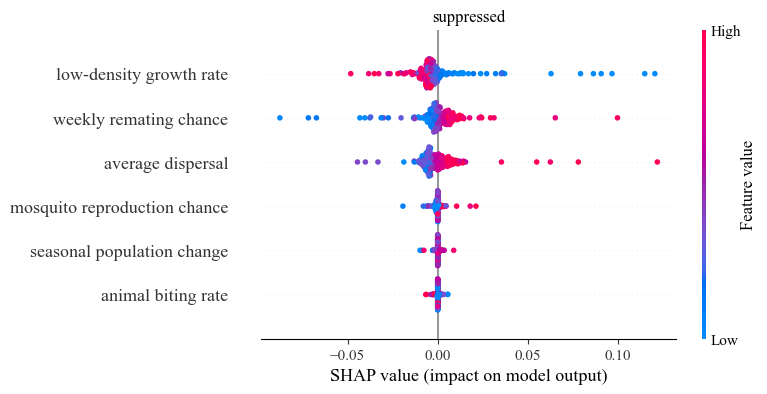

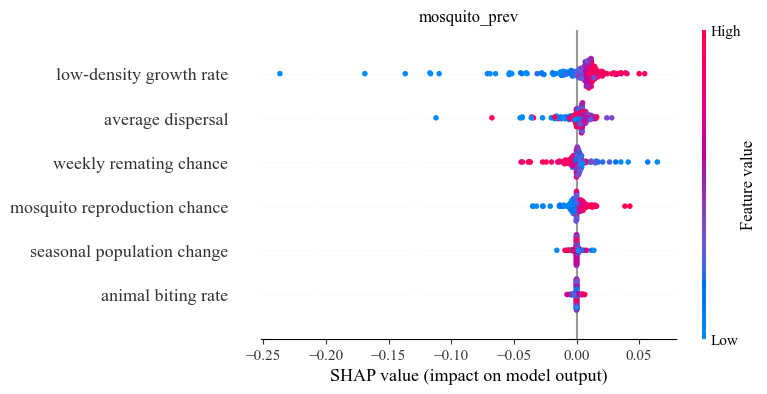

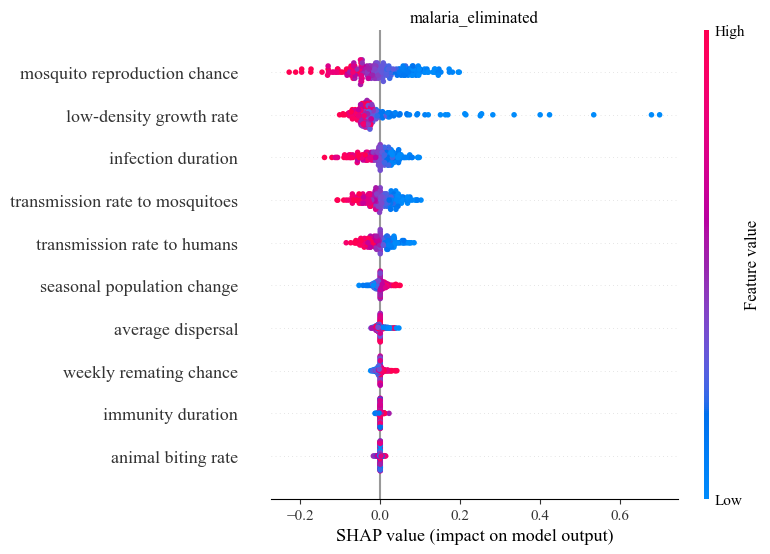

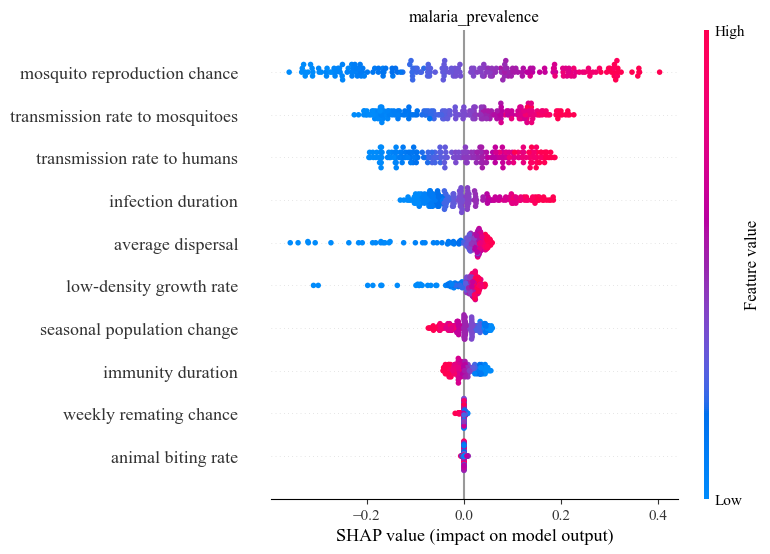

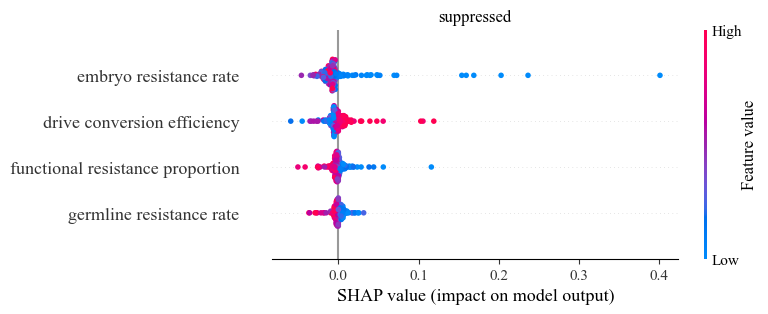

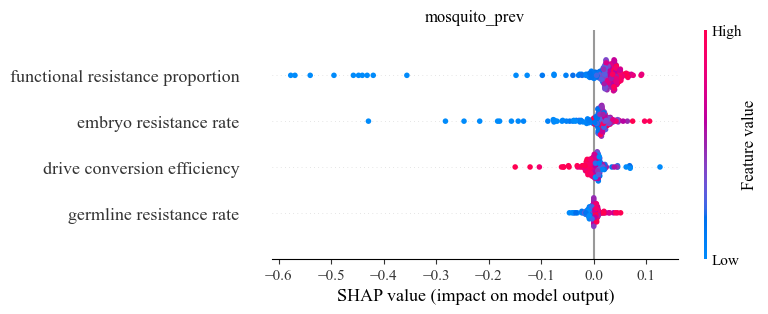

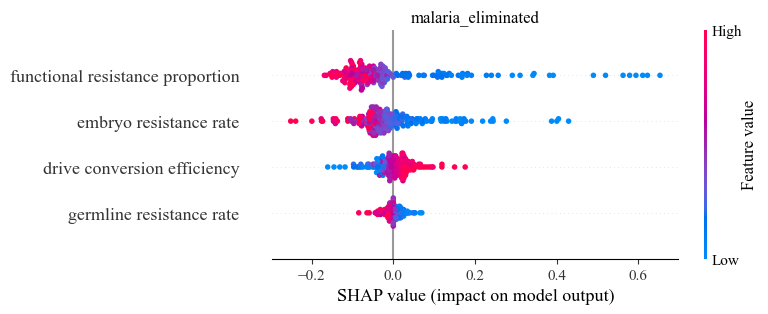

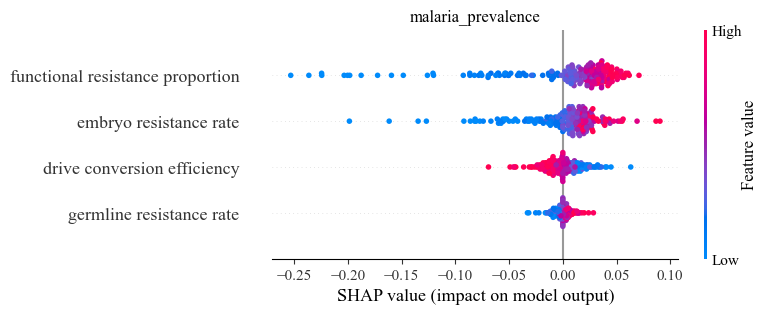

In [71]:

ecological={'transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'average dispersal',
        'weekly remating chance',
        'mosquito reproduction chance', 
        'animal biting rate','low-density growth rate',
        'seasonal population change',
        'infection duration',
        'immunity duration'}
drive={'drive fitness', 
        'female heterozygote fitness',
        'germline resistance rate',
        'drive conversion efficiency',
        'embryo resistance rate', 
        'functional resistance proportion'}
#for individual models only
setname=['ecological','drive']
sets=[ecological,drive]
X_train_mos = X_train.loc[:,mosquito_parameter]
#parameters
for paras_i in range(2):
    
    loci=np.array([i for i in range(len(X_train_mos.columns)) if X_train_mos.columns[i] in sets[paras_i]])
    n=0
    for label_idx, label in enumerate(list_of_labels2):
        # Create a new figure for each plot
        plt.figure()
        # Generate the SHAP plot
        shap.summary_plot(shap_values=shap_value2[n][:,loci],features=X_train_mos.iloc[0:200, loci], show = False)
        # Set the title
        plt.title(label)
        n+=1
        # Save the figure to the png
        plt.savefig('D://research//malaria//Paper_writing//Figures//shap//'+setname[paras_i]+'shape_mosquito '+str(label)+'.png')
    

    # Close the PDF file
    loci=np.array([i for i in range(len(X_train.columns)) if X_train.columns[i] in sets[paras_i]])
    n=0
    for label_idx, label in enumerate(list_of_labels1):
        # Create a new figure for each plot
        plt.figure()
        # Generate the SHAP plot
        shap.summary_plot(shap_values=shap_value1[n][:,loci],features=X_train.iloc[0:200, loci], show = False)
        # Set the title
        plt.title(label)
        n+=1
        # Save the figure to the png
        plt.savefig('D://research//malaria//Paper_writing//Figures//shap//'+setname[paras_i]+'shap_malaria '+str(label)+'.png')

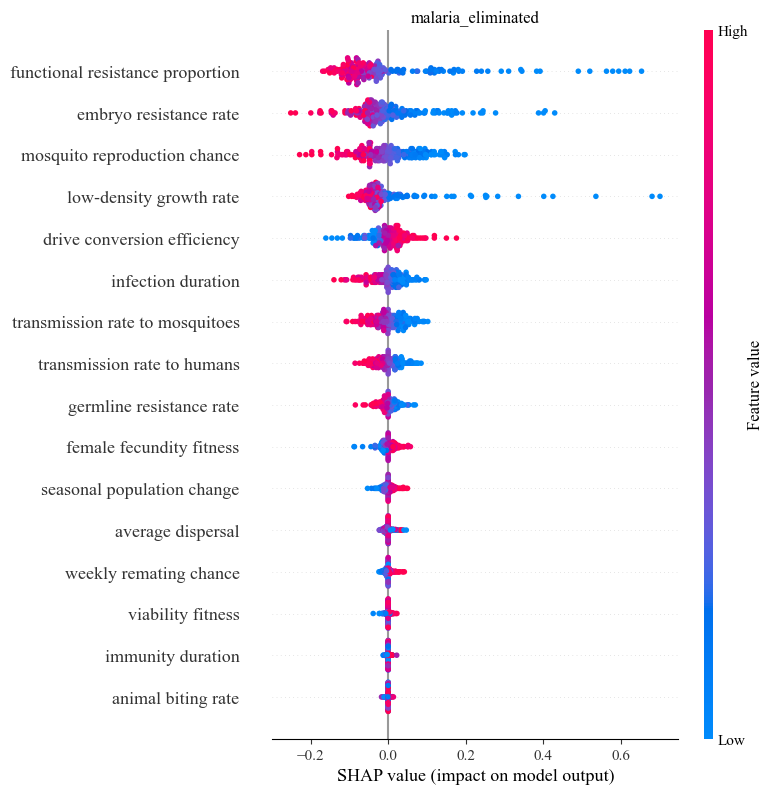

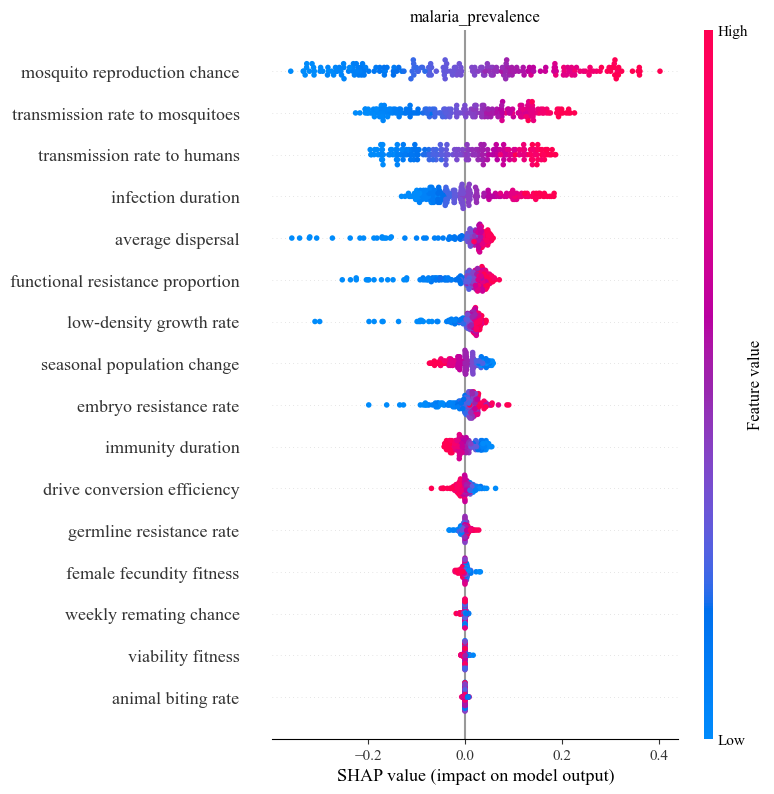

In [80]:
n=0
for label_idx, label in enumerate(list_of_labels1):
        # Create a new figure for each plot
        plt.figure()
        # Generate the SHAP plot
        shap.summary_plot(shap_values=shap_value1[n],features=X_train.iloc[0:200, :], show = False)
        # Set the title
        plt.title(label)
        n+=1
        # Save the figure to the png
        plt.savefig('D://research//malaria//Paper_writing//Figures//shap//'+'shap_malaria '+str(label)+'.png')

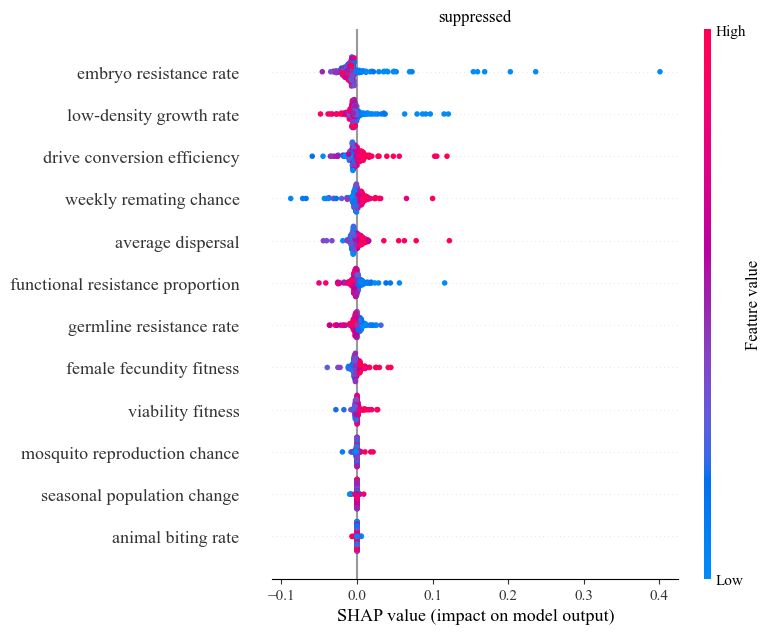

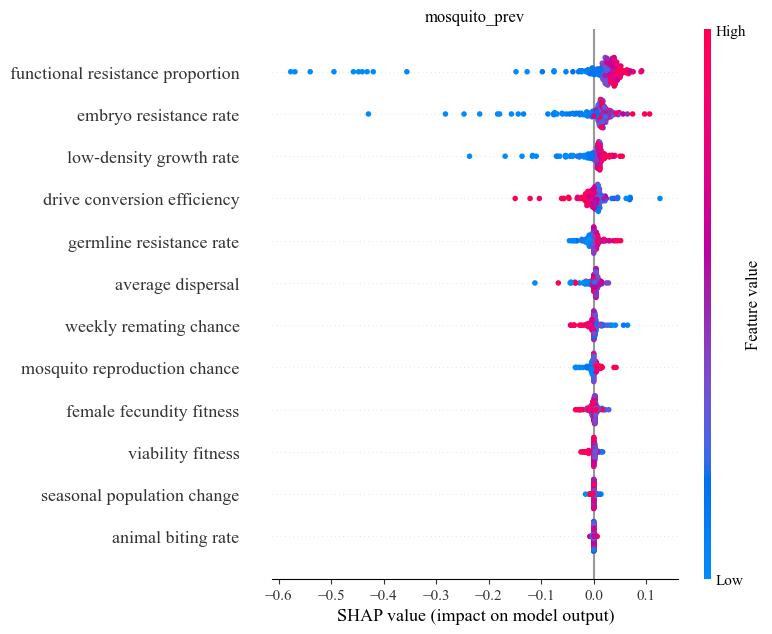

In [81]:
n=0
for label_idx, label in enumerate(list_of_labels2):
        # Create a new figure for each plot
        plt.figure()
        # Generate the SHAP plot
        shap.summary_plot(shap_values=shap_value2[n],features=X_train_mos.iloc[0:200, :], show = False)
        # Set the title
        plt.title(label)
        n+=1
        # Save the figure to the png
        plt.savefig('D://research//malaria//Paper_writing//Figures//shap//'+'shap_mosquito '+str(label)+'.png')